# Lab 2. Task 8. 
Author: Pyatkin Stanislav.

Task: Implement ELBO for regression problem with known posterior. Optimize hyperparameters naively, using maximum likelihood method (see article). Visulize difference between optimized hyperparameters and tru hyperparameters.


## Theory

Regression problem: \\
$(x, y) \sim p(x, y)$ \\

$D = \{ (x_i, y_i)\}_{i=1}^N$, all $(x_i, y_i)$ is i.i.d.

Model $p(y | x, w)$, where $w$ - some parameters. Let $w \sim p_\alpha(w)$. We need to choose model (parameters), that reproduce data $D$ in the best way.

The solution of problem is $w^{\star} = argmax_w ~p(w | D)$.

It is difficult to estimate $p(w | D)$, so let's approximate it $p(w | D) ≈ q_\beta(w)$ and find the best approximation.

$$\log{p(D)} = \int q_\beta(w) \log{p(D)} dw = \int q_\beta(w) \log{\frac{p(D, w)}{q_\beta(w)}\frac{q_\beta(w)}{p(w|D)}} dw = \int q_\beta(w) \log{\frac{p(D, w)}{q_\beta(w)} dw + \int q_\beta(w) \log{\frac{q_\beta(w)}{p(w|D)}}} dw = \mathbb{E}_{q_\beta(w)} \log{\frac{p(D, w)}{q_\beta(w)}} + D_{KL}(q_\beta(w)||p(w|D))$$

Let $$L(\alpha, \beta, D) = \mathbb{E}_{q_\beta(w)} \log{\frac{p(D, w)}{q_\beta(w)}}.$$

$\log{p(D)} = const$, so if we will maximize $L(\alpha, \beta, D)$ then we will automatically minimize $D_{KL}(q_\beta(w)||p(w|D))$. Minimizing of  KL-divergence means better approximation $p(w|D)$ by $q_\beta(w)$

$$L(\alpha, \beta, D) = \mathbb{E}_{q_\beta(w)}\log{\frac{p(D, w)}{q_\beta(w)}} = \mathbb{E}_{q_\beta(w)}\log{p(D|w)} - D_{KL}(q_\beta(w)||p_\alpha(w))$$

Prior and posterior distributions can be different. See at table from [paper](https://www.cs.toronto.edu/~graves/nips_2011.pdf):

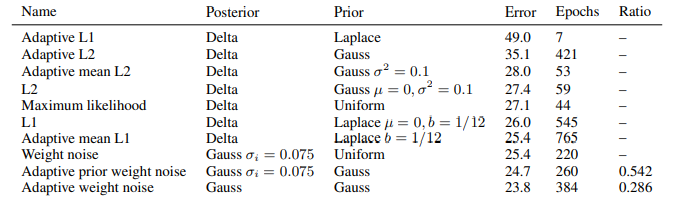

1. Maximum likelihood 

$p_\alpha(w) = const$

$q_\beta(w) = \delta(w - \beta)$

$$L(\alpha, \beta, D) = \mathbb{E}_{q_\beta(w)}\log{\frac{p(D, w)}{q_\beta(w)}} = \mathbb{E}_{q_\beta(w)}\log{p(D|w)} - D_{KL}(q_\beta(w)||p_\alpha(w))$$

$\mathbb{E}_{q_\beta(w)}\log{p(D|w)} = \log{p(D|\beta)}$

$D_{KL}(q_\beta(w)||p_\alpha(w)) = -\log{p_\alpha(\beta)} = C$

$$L(\alpha, \beta, D) = \log{p(D|\beta)} + C$$

2. Adaptive weight noise

$p_\alpha(w) \sim N(\mu_1, \sigma_1^2) $

$q_\beta(w) \sim N(\mu_2, \sigma_2^2) $

## Experemental model

Model: $y = x^Tw$.

Points: $y_i = x_i^Tw + \varepsilon_i, i=1, \dots, N$.

$\varepsilon_i \sim N(0, 1)$

Matrix form: $y = Xw + \epsilon$.

Prior of weights: $w \sim N(0, 1)$.

Let's find posterior of weights:
$$p(w|D) \propto p(D|w)p(w) = \prod_{i=1}^{N}{p(y_i|x_i, w)} p(w) \propto \exp((y - Xw)^T(y - Xw))\exp(w^Tw)$$

$$(y - Xw)^T(y - Xw) + w^Tw = (w - \mu)^TA(w - \mu) + y^Ty - \mu^TA\mu,$$ where $A = (X^TX + I), \mu = A^{-1}X^Ty.$

$$p(w|D) \propto \exp(w - \mu)^TA(w - \mu) \Rightarrow p(D|w) \sim N(\mu, A^{-1})$$

## Code

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from jax import grad, jit, vmap

In [24]:
# Generate data
r = 10
key = random.PRNGKey(1)
key_w, key_X, key_e = random.split(key, 3)
w = random.normal(key_w, (r,))

N = 100
X = random.normal(key_X, (N, r)) * 10
y = X @ w 
y += random.normal(key_e, y.shape)

### Experiment 1.

In [25]:
key = random.PRNGKey(2)
key_w, key_X, key_e = random.split(key, 3)

norms_elbo_mle = []
norms_elbo_w = []
norms_w_mle = []
Ns = []

for i in range(1, 10):
  N = 10*i
  X_i = random.normal(key_X, (N, r)) * 10
  y_i = X_i @ w 
  y_i += random.normal(key_e, y_i.shape)

  # Analitical solution of posterior
  A = X_i.T @ X_i + jnp.eye(r)
  mu_elbo = jnp.linalg.inv(A) @ X_i.T @ y_i

  # ELBO solution of posterior Maximum likelihood
  mu_mle = jnp.linalg.inv(X_i.T @ X_i) @ X_i.T @ y_i

  norms_elbo_mle.append(jnp.linalg.norm(mu_mle - mu_elbo))
  norms_elbo_w.append(jnp.linalg.norm(w - mu_elbo))
  norms_w_mle.append(jnp.linalg.norm(mu_mle - w))
  Ns.append(N)

Let's look at dependency difference between MLE, ELBO solution and true weights from N.

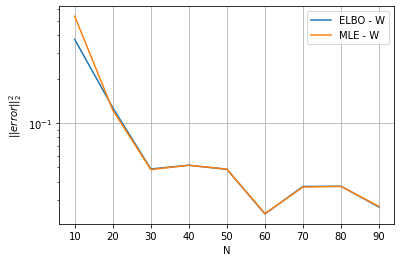

In [26]:
# plt.plot(Ns, norms_elbo_mle, label="ELBO - MLE")
plt.plot(Ns, norms_elbo_w, label="ELBO - W")
plt.plot(Ns, norms_w_mle, label="MLE - W")

plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('N')
plt.ylabel('$||error||^2_2$')

plt.show()

### Experiment 2.

Find numerical solution for ELBO.

In [27]:
# Global parameters for ELBO method
K = 15
step_size = 1e-4

def generate(params, key):
  """
  Generate parameters w ~ N(mus, sigmas**2)
  """
  mus, log_sigmas = params
  sigmas = jnp.exp(log_sigmas)
  w = mus + sigmas * random.normal(key, mus.shape)
  return w

def ELBO(alpha, beta, X, y):
  """
  Estimate ELBO by Monte-Carlo method
  Global constant: K
  """
  keys = random.split(random.PRNGKey(0), K)
  S = 0
  for key in keys:
    w = generate(beta, key)
    # S += -(y - X @ w).T @ (y - X @ w)/2
    S += -((y - X @ w)**2).mean()/2

  # KL-divergence for two normal random variables
  D_KL = alpha[1]-beta[1] + (jnp.exp(beta[1])**2 + (beta[0] - alpha[0])**2)/(2*jnp.exp(alpha[1])**2)
  return S/(K) - D_KL.sum()

@jit
def update(alpha, beta, X, y):
  """
  Update parameters alpha, beta
  Global constant: step_size
  """
  grads = grad(ELBO, argnums=(0, 1))(alpha, beta, X, y)
  alpha_grad, beta_grad = grads

  return ((alpha[0] + step_size*alpha_grad[0], alpha[1] + step_size*alpha_grad[1]), 
          (beta[0] + step_size*beta_grad[0], beta[1] + step_size*beta_grad[1]))

In [28]:
# Analitical solution of posterior
A = X.T @ X + jnp.eye(r)
mu = jnp.linalg.inv(A) @ X.T @ y

# ELBO solution of posterior Maximum likelihood
beta_hat = jnp.linalg.inv(X.T @ X) @ X.T @ y

#ELBO solution of posterior Adaptive weight noise
keys = random.split(random.PRNGKey(9), 4)
alpha = (random.normal(keys[0], (r,)), random.normal(keys[1], (r,)))
beta = (random.normal(keys[2], (r,)), random.normal(keys[3], (r,)))

epochs = 1000

betas = []
for _ in range(epochs): 
  alpha, beta = update(alpha, beta, X, y)
  betas.append(beta[0])

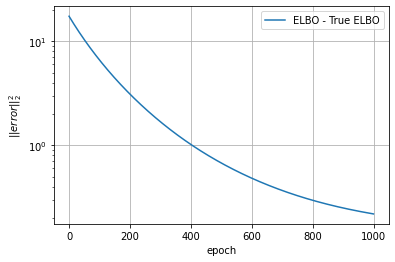

Last norm of difference between analitical and numerical solution 0.21886197


In [22]:
norms = [jnp.linalg.norm(beta - mu) for beta in betas]

plt.plot(range(len(norms)), norms, label="ELBO - True ELBO")
plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('$||error||^2_2$')

plt.show()
print('Last norm of difference between analitical and numerical solution', norms[-1])

## Conclusion

+ For this case MLE and ELBO solutions are very close.
+ For numerical ELBO solution the rate of convergence to true posterior by the gradient method is low. 